# Minimal Demo

This notebook will use the small test data shapefiles to build a graph and find distances.

In [1]:
# the pylab line is just for the notebook
# it's not required elsewhere:
# https://stackoverflow.com/questions/20961287/what-is-pylab
%pylab inline
import fiona
import pyriv
import os # used for file paths
import geopandas as gpd # for accessing shapefiles

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_dir = "../tests/testdata/"
fp = lambda s: os.path.join(data_dir, s)
out_dir = "/Users/jkibele/Documents/temp/"
outfp = lambda s: os.path.join(out_dir, s)

In [3]:
land_fn = fp('CoastLine.shp')
rivers_fn = fp('Rivers.shp')
points_fn = fp('UpriverTestPoints.shp')

Load points to use as test locations.

In [4]:
test_points = gpd.read_file(points_fn)

## Simple Case

For this case we'll assume that all of our input data is perfect. All river dead ends are rivermouths, and the rivermouths are nodes on the coastline. First we'll work with just the rivers, and generate distances for a set of points up the rivers. 

Then, we'll generate a coastal network, join it to the river network, and calculated distances between points and a distance matrix for the full set up points.

## Build Directional River Network

Load a river shapefile, but don't load a coast shapefile. This will assume that all dead ends are rivermouths.

In [5]:
rivnet = pyriv.RiverGraph(data=rivers_fn)

Get the end points of the rivers, and display them along with the rivers edges and nodes as plotted by the Networkx `draw_networkx_edges` method. In this representation, the edges between nodes are shown as "arrows" (though the head of the arrow is just a wider line segment rather than a triangle) that indicate flow direction. The "arrow" segments are displayed as straight lines between nodes. However, the river geometry between nodes is preserved within the edge attributes as seen in the next representation.

/usr/local/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/usr/local/lib/python2.7/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:


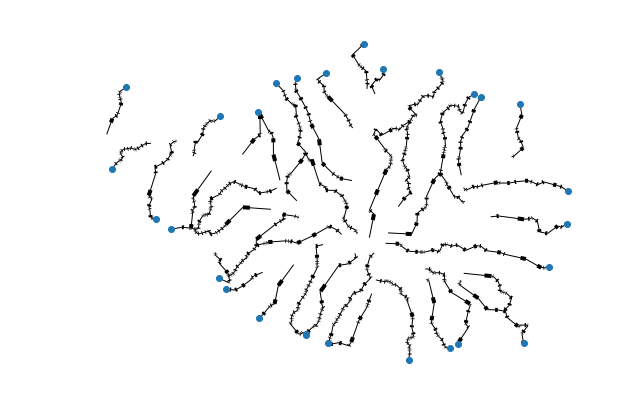

In [6]:
# get the river end points
riv_end_pnts = rivnet.deadend_gdf()
# plot the rivers and their end points
figsize(10,8)
ax = riv_end_pnts.plot(zorder=2)
rivnet.plot(ax=ax, zorder=1)
ax.set_axis_off()
# if you want to see this on a zoomable slippy map
# make sure mplleaflet is installed and uncomment 
# these lines
# import mplleaflet
# mplleaflet.display(epsg=3338)

Or, if you don't want to see the river nodes, simply use the `RiverGraph.summary_plot` method.

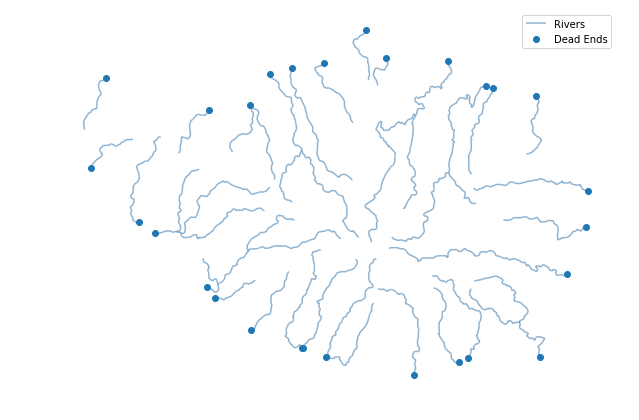

In [7]:
ax = rivnet.summary_plot()
legend() # pylab method for displaying legend.
ax.set_axis_off()

### Find Path to Ocean for 1 Point

Find the path from a point downstream to the deadend (presumably a rivermouth), and report the length (in meters - pyriv must be used with data in a projection with meters as the units). The `shortest_path_to_deadend` method takes a `RiverGraph` node (identified by it's position) as input to determine the starting node. So, for an arbitrary point that is not exactly on a node, we must use the `closest_node` method to convert the point to a starting node.

In [8]:
p0 = test_points.iloc[0].geometry
node0 = rivnet.closest_node(p0)
p0_path = rivnet.shortest_path_to_deadend(node0)
p0_path.length

18572.891085077586

Display the results graphically.

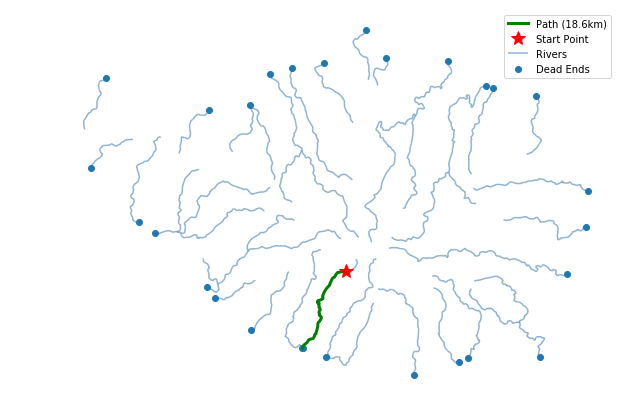

In [9]:
# plot the rivers and their end points
figsize(10,8)
ax = rivnet.summary_plot()
ax.set_axis_off()
# plot the path and start point
pthx, pthy = p0_path.xy
pthlbl = "Path ({:.1f}km)".format(p0_path.length * 1e-3)
ax.plot(pthx, pthy, c='g', zorder=2, linewidth=3, label=pthlbl)
ax.plot(*p0.xy, marker='*', markersize=15, c='r', 
        label='Start Point', linewidth=0)
foo = legend()

### Find Distances for All Test Points

For each point in the point shapefile referenced by the path `points_fn`, we'll find the path to the nearest dead end (assumed to be a rivermouth). The `pyriv.RiverGraph.river_distances` method returns a `pyriv.RiverDist` object which is really a `geopandas.GeoDataFrame` with a few extra methods and properties. The result for our test data contains 6 rows, but we'll just display the first 3 in tabular format.

In [10]:
rivgdf = rivnet.river_distances(points_fn)
rivgdf.head(3)

,id,geometry,path,rivdist_km,nearest_node,node_dist
0,1,POINT (-686159.3402290039 1176410.600136723),LINESTRING (-685865.8326982833 1176470.4243199...,18.572891,POINT (-685865.833 1176470.424),299.541964
1,2,POINT (-682115.1922568978 1176121.732424429),LINESTRING (-682148.8606086159 1175861.2928523...,20.146047,POINT (-682148.861 1175861.293),262.606698
2,3,POINT (-678107.1527488284 1173196.94683746),LINESTRING (-678159.8846274239 1173207.4960501...,19.569260,POINT (-678159.885 1173207.496),53.777088


Plot a visual summary of the results.

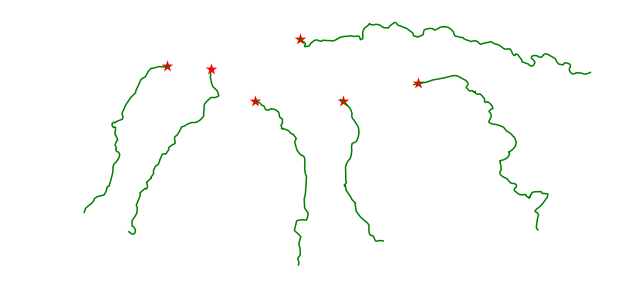

In [11]:
ax = rivgdf.summary_plot()
ax.set_axis_off()

Combine the river graph summary plot with the results summary plot.

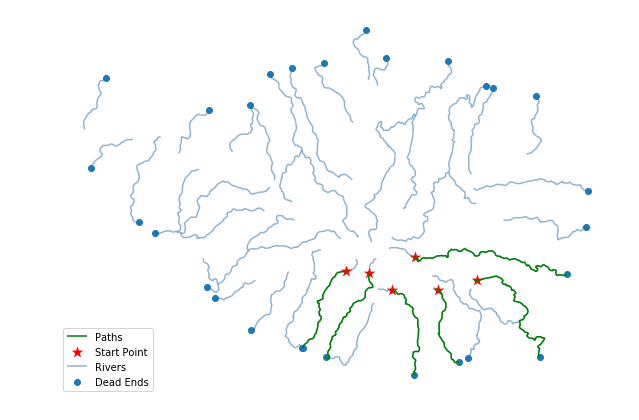

In [12]:
ax = rivgdf.summary_plot()
ax = rivnet.summary_plot(ax=ax)
legend(loc='lower left')
ax.set_axis_off()

In [13]:
rivnet.write_gpickle(outfp("test.gpickle"))

## Build the Coastal Network

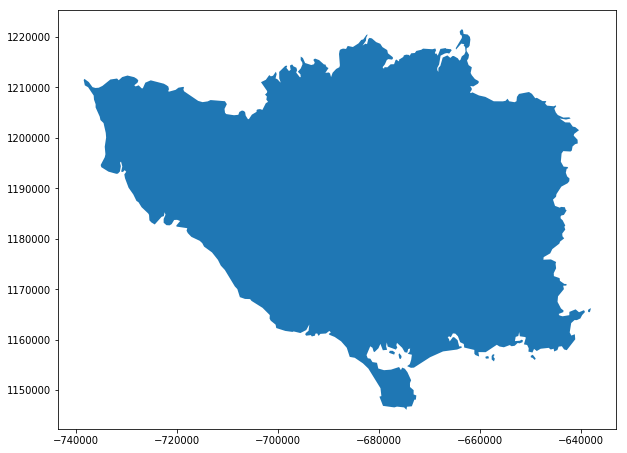

In [14]:
clg = pyriv.CoastLine.read_shp(land_fn)
lnd = pyriv.Land(clg.poly_geodataframe(), simplify_tolerance=100)
lnd.plot()

In [15]:
lnd.complexity_statement()

'635 nodes and around 402590 edge possibilities.'

In [17]:
%%time 
# about 1.25 min on MBP using 6 processors
mg = lnd.build_graph(verbose=True)
mg.write_gpickle(outfp("mad_graph.gpickle"))
# mg = pyriv.MadGraph.from_gpickle(outfp("mad_graph.gpickle"))

Starting at Fri Jul 20 10:41:20 2018 to add edges for 628 nodes.
We'll have to look at somewhere around 393756 edge possibilities.
It took 1 minutes to load 8412 edges.
CPU times: user 424 ms, sys: 96.4 ms, total: 521 ms
Wall time: 1min 22s


In [18]:
len(mg.edges())

8412

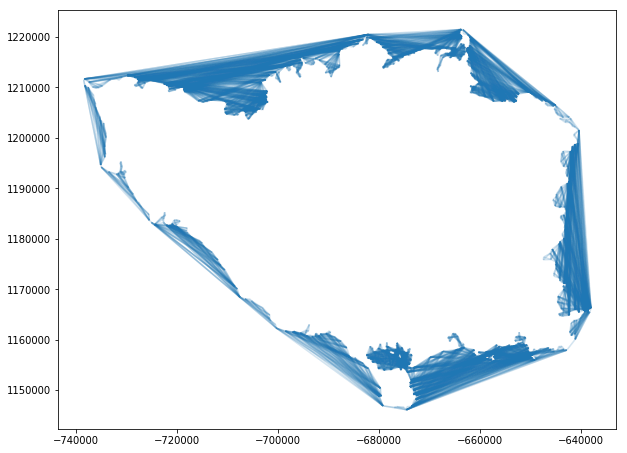

In [19]:
mg.edge_geodataframe.plot(alpha=0.1)

## Joining Graphs

In order to properly join the river graph to the coastal `MadGraph`, we need to differentiate dead ends. In order to do this, the `RiverGraph` needs to understand where the land is. So, we'll make a new `RiverGraph` that uses the `coastline` attribute.

In [20]:
rivnet2 = pyriv.RiverGraph(data=rivers_fn, coastline=lnd, riv_mouth_buffer=50)

Here are the "deadend" types. The "Inland" nodes are on land and their distance from the coast (the exterior ring of the `coastline` polygon) is greater than `riv_mouth_buffer`. "Coastal" nodes are on land but within the `riv_mouth_buffer` distance. "Coast Node" deadends are within `tolerance` (default 1e-5 meters) of a coast node (meant to be equivalent after rounding). "Ocean" deadends are not on land.

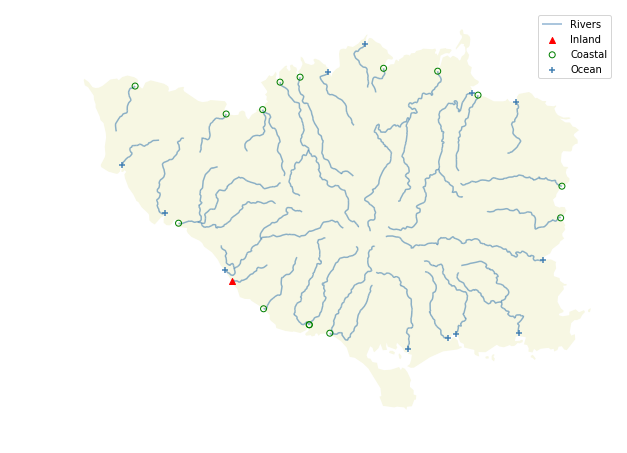

In [21]:
ax = rivnet2.summary_plot()
ax.set_axis_off()
foo = legend()

Now the `auto_complete` method will be used to add in additional short edges to convert "Coastal" nodes to "Coast Nodes".

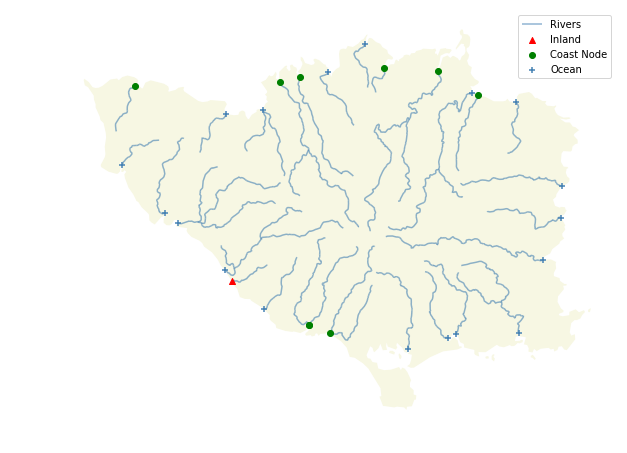

In [22]:
rivnet2.auto_complete()

ax = rivnet2.summary_plot()
ax.set_axis_off()
foo = legend()

Mock up:

```python
full_mad_graph = rivnet2.join_mad_graph(mg)
```

In [23]:
mg.__class__

pyriv.mad_graph.MadGraph

In [27]:
mg.is_directed()

True